# Getting Started

This tutorial demonstrates how to quickly get started with the HSSM package. We will cover the following steps:

- How to create a model
- How to create some simple simulated data
- How to specify parameters
- How to specify parameters with regressions
- How to use ArviZ to summarize and visualize the traces.

## Colab Instructions

If you would like to run this tutorial on Google colab, please click this [link](https://github.com/lnccbrown/HSSM/blob/main/docs/tutorial_notebooks/no_execute/getting_started.ipynb). 

Once you are *in the colab*, follow the *installation instructions below* and then **restart your runtime**. 

Just **uncomment the code in the next code cell** and run it!

**NOTE**:

You may want to *switch your runtime* to have a GPU or TPU. To do so, go to *Runtime* > *Change runtime type* and select the desired hardware accelerator.

Note that if you switch your runtime you have to follow the installation instructions again.

In [ ]:
# !pip install numpy==1.23.4
# !pip install git+https://github.com/lnccbrown/hssm@main
# !pip install git+https://github.com/brown-ccv/hddm-wfpt@main
# !pip install numpyro

## Import Modules

In [1]:
import arviz as az
import bambi as bmb  # only necessary if you want to specify priors using bmb.Prior
import numpy as np
import hssm

### Setting the global float type

**Note**: Using the analytical DDM (Drift Diffusion Model) likelihood in PyMC without setting the float type in `PyTensor` may result in warning messages during sampling, which is a known bug in PyMC v5.6.0 and earlier versions. To avoid these warnings, we provide a convenience function:

In [2]:
hssm.set_floatX("float32")

## Simulating a dataset

The `hssm.simulate_data()` function generates data for most SSM types. Here we simulate some data from a Drift Diffusion Model (DDM) with known true parameter values.

In [3]:
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.5]
dataset = hssm.simulate_data(
    model="ddm",
    theta=[v_true, a_true, z_true, t_true],
    size=1000,
)

dataset

,rt,response
0,3.880937,1.0
1,1.615996,-1.0
2,2.477036,1.0
3,2.384032,1.0
4,2.129020,1.0
...,...,...
995,3.504965,1.0
996,1.616996,1.0
997,1.468991,1.0
998,1.162995,1.0


## Model specification

### 1. DDM using defaults

We begin with a simple example. The only information required to create a model in `HSSM` is a dataset.

A dataset in `HSSM` is typically a `pandas` `DataFrame` with at least `rt` and `response` columns, which indicates response time and choices respectively. Right now, `response` only accepts values of `1` and `-1`.

If none of the optional parameters is provided, HSSM will assume that we are modeling a classical DDM model with `v`, `a`, `z`, and `t` as its parameters. HSSM also provides a default analytical likelihood function and some uninformative priors. These can all be overriden by user inputs.

In [4]:
simple_ddm_model = hssm.HSSM(data=dataset)
simple_ddm_model

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Prior: Uniform(lower: -10.0, upper: 10.0)
    Explicit bounds: None
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: None
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: Uniform(lower: 0.0, upper: 2.0, initval: 0.10000000149011612)
    Explicit bounds: None

#### Visualizing the model

If you have `graphviz` installed on your machine, you will also be able to visualize the model. Please uncomment the code and run it if you have `graphviz` installed.

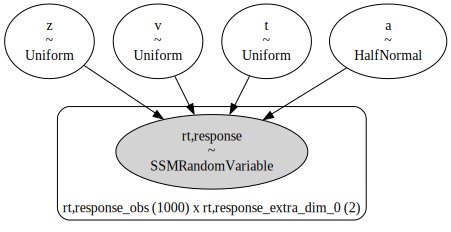

In [5]:
# Uncomment if you have graphviz installed
# simple_ddm_model.graph()

#### Performing MCMC sampling

Similar to `PyMC`, HSSM provides the `sample()` method once the model is created to perform MCMC sampling. By default, it uses `PyMC`'s `NUTS` sampler. We can use other samplers, which we will cover soon.

In [6]:
simple_ddm_model.sample()

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v]
INFO:pymc.sampling.mcmc:NUTS: [z, a, t, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

#### Visualizing the traces with `ArviZ`

Like that of `pm.sample()`, the result of `model.sample()` is also an `az.InferenceData` object, which can be used with the `ArviZ` package. The last sample the model has performed is stored in the `model.traces` property for eazy access. Here we use the `az.summary()` and `az.plot_trace()` functions to generate a summary table and diagnostic plots for the samples.

In [7]:
az.summary(simple_ddm_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.488,0.012,0.465,0.510,0.000,0.0,2872.0,3015.0,1.0
a,1.554,0.027,1.503,1.606,0.001,0.0,2621.0,2860.0,1.0
t,0.455,0.022,0.410,0.491,0.000,0.0,2436.0,2157.0,1.0
v,0.512,0.028,0.459,0.565,0.001,0.0,3028.0,2959.0,1.0


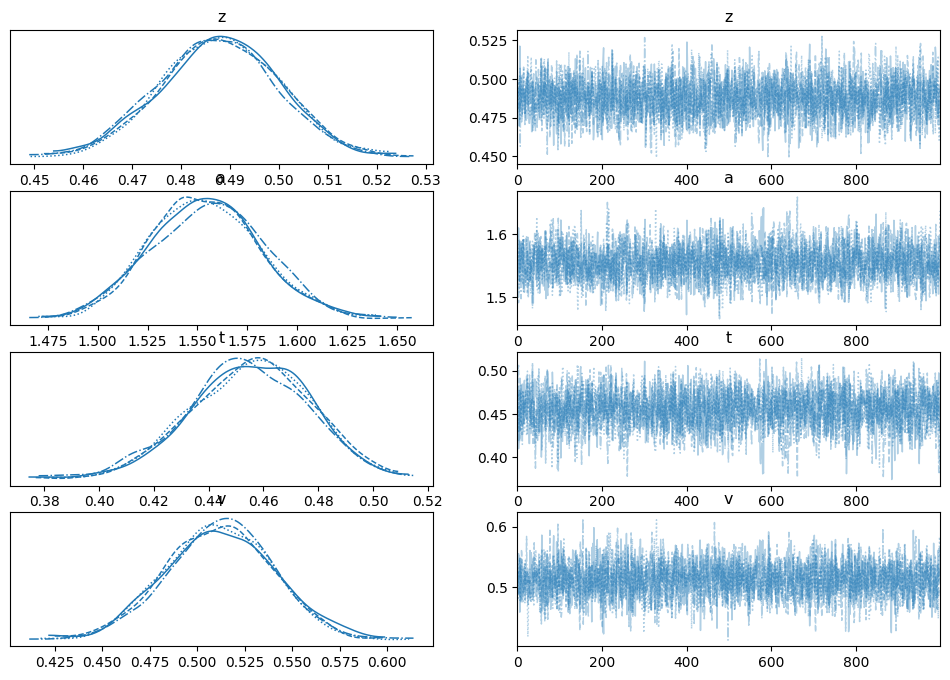

In [8]:
az.plot_trace(simple_ddm_model.traces);

**Congratulations**! You have just created and sampled from your first model in HSSM! Parameter recovery seems to be pretty successful.

### 2. Specifying different model types

The default model in HSSM is the classic DDM, but HSSM supports many other model types. Below is a full list of supported models at the moment. We will add new models, and HSSM users can also contribute models. Please [click here](https://lnccbrown.github.io/HSSM/CONTRIBUTING/) for our contribution guidelines.

- ddm
- ddm_sdv
- angle
- levy
- ornstein
- weibull
- race_no_bias_angle_4
- ddm_seq2_no_bias

For more information about these models, please [see here](https://lnccbrown.github.io/HSSM/api_defaults/#wfpt-and-wfpt_sdv-classes).

To model a different model type, please use the `model` parameter of the HSSM class constructor. 

If `model` provided is one of the supported models above, HSSM also has default specifications for these models. No other specifications is necessary.

If `model` provided is not one of the above, then HSSM considers that you are using a custom model. We will cover custom models in more detail in a separate tutorial.

Below is an example of specifying the `angle` model type.

In [9]:
# Simulate data for an angle model
angle_data = hssm.simulate_data(
    model="angle",
    theta=[0.5, 1.5, 0.5, 0.5, 0.3],  # true values
    size=1000,
)

angle_model = hssm.HSSM(data=angle_data, model="angle")
angle_model

Hierarchical Sequential Sampling Model
Model: angle

Response variable: rt,response
Likelihood: approx_differentiable
Observations: 1000

Parameters:

v:
    Prior: Uniform(lower: -3.0, upper: 3.0)
    Explicit bounds: (-3.0, 3.0)
a:
    Prior: Uniform(lower: 0.30000001192092896, upper: 3.0)
    Explicit bounds: (0.3, 3.0)
z:
    Prior: Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)
    Explicit bounds: (0.1, 0.9)
t:
    Prior: Uniform(lower: 0.0010000000474974513, upper: 2.0)
    Explicit bounds: (0.001, 2.0)
theta:
    Prior: Uniform(lower: -0.10000000149011612, upper: 1.2999999523162842)
    Explicit bounds: (-0.1, 1.3)

`angle` models, by default, use an approximate differentiable likelihood function that relies on JAX for likelihood computation. At the moment, due to the different ways `JAX` and `Jupyter` handle parallelism, parallel sampling is not available for this type of likelihood computations. There are ways to get around this, but for now, let's just perform sequential sampling with just one core.

**Note**: the `sample()` method internally calls `bambi`'s `fit()` fit method, which internally calls `pymc`'s `sample()` function. This means that HSSM's `sample()` method will accept most parameters accepted by the two other functions. You could pretty much use it just like the `pm.sample()` function.

In [10]:
angle_model.sample(cores=1, chains=2)

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
NUTS: [z, t, theta, a, v]
INFO:pymc.sampling.mcmc:NUTS: [z, t, theta, a, v]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 115 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 115 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [11]:
az.summary(angle_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.494,0.012,0.473,0.518,0.000,0.000,915.0,1045.0,1.0
t,0.492,0.029,0.433,0.540,0.001,0.001,594.0,765.0,1.0
theta,0.307,0.028,0.253,0.357,0.001,0.001,605.0,819.0,1.0
a,1.515,0.062,1.396,1.627,0.003,0.002,556.0,739.0,1.0
v,0.496,0.042,0.423,0.577,0.001,0.001,919.0,888.0,1.0


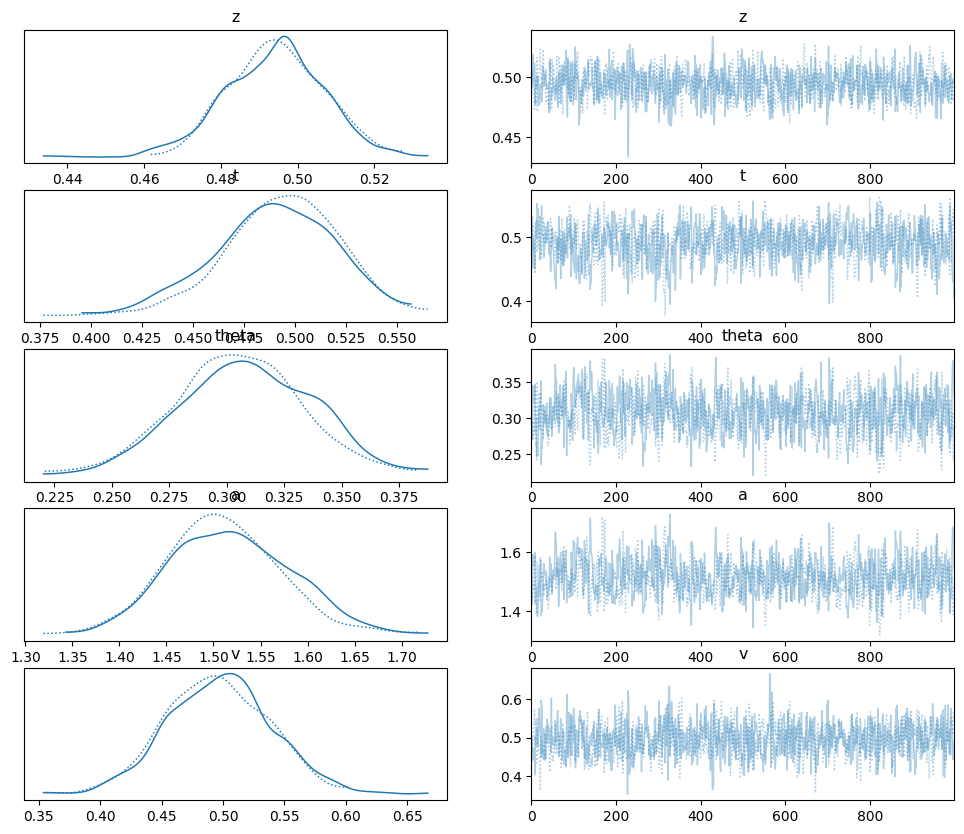

In [12]:
az.plot_trace(angle_model.traces);

### 3. Specifying priors: the non-regression case

Next, let's take a look at how to specify priors in the non-regression case. In HSSM, parameter specification can be done in two ways:

1. through the `include` parameter, or
2. through a shortcut

#### 3.1 Specifying priors through the `include` parameter

The `include` parameter accept a list of dictionaries. In the non-regression case, each dictionary typically looks like this:

```python
{
    "name": "v",
    "prior": {
        "name": "Uniform",
        "lower": -5.0,
        "upper": 5.0,
    },
    "bounds": (-10.0, 10.0)
}
```

The `name` field corresponds with the name of the parameter being specified.

The `prior` field specifies the distribution of the prior. There are two ways to achieve this:

1. A dictionary with the `name` of the distribution (**typically captalized**) and the parameters of the distribution that you would typically set if you were specifying a distribution in `PyMC`. For example, if you would like to specify `pm.Normal(mu=0.0, sigma=1.0)` as the prior, then in `HSSM`, this prior dictionary would be:

```python
{
    "name": "Normal", ## Note it is capitalized
    "mu": 0.0,
    "sigma": 1.0,
}
```

or, using the `dict` function:

```python
dict(name="Normal", mu=0.0, sigma=1.0)
```

2. A `bmb.Prior` object. This is exactly how you would specify priors using `bambi`. Assuming you have imported bambi like this: `import bambi as bmb`. Then to specify the same normal prior as above, you would write:

```python
bmb.Prior("Normal", mu=0.0, sigma=1.0)
```

The `bounds` field accepts a tuple of floats, indicating the lower and upper bounds for the parameter.

**Fixing parameters**: sometimes you might want to fix the values of a parameter. You can easily do so by specifying that value to the `prior` field of the dictionary. In the following example, the paramter `v` is fixed to `0.5`.

```python
{
    "name": "v",
    "prior": 0.5,
}
```

Now let's make this concrete with an example:

In [13]:
# A Normal prior for `v` without explicit bounds
param_v = {
    "name": "v",
    "prior": {
        "name": "Normal",
        "mu": 0.0,
        "sigma": 2.0,
    },
}

# A Uniform prior for `a`. Using the `dict` function
param_a = {
    "name": "a",
    "prior": dict(
        name="Uniform",
        lower=0.01,
        upper=5,
    ),
    "bounds": (0, 1e5),
}

# A Uniform prior for `z` over (0, 1) set using bmb.Prior.
# bounds are not set, existing default bounds will be used
param_z = {"name": "z", "prior": bmb.Prior("Uniform", lower=0.0, upper=1.0)}

# A fixed value for t
param_t = {"name": "t", "prior": 0.5}

example_ddm_model = hssm.HSSM(
    data=dataset,
    model="ddm",
    include=[
        param_v,
        param_a,
        param_z,
        param_t,
    ],
)

example_ddm_model

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: None
a:
    Prior: Uniform(lower: 0.009999999776482582, upper: 5.0)
    Explicit bounds: (0.0, 100000.0)
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Value: 0.5

In [14]:
example_ddm_model.sample()

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, v]
INFO:pymc.sampling.mcmc:NUTS: [z, a, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [15]:
az.summary(example_ddm_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.492,0.028,0.440,0.544,0.001,0.0,2963.0,2746.0,1.0
z,0.500,0.011,0.480,0.521,0.000,0.0,2482.0,3083.0,1.0
a,1.520,0.021,1.481,1.557,0.000,0.0,3636.0,3158.0,1.0


#### 3.2 Specifying priors using the shortcut

HSSM also supports a syntax very similar to `PyMC`: You can directly specify priors by passing the prior to the name of the parameter in `hssm.HSSM`. This is convenient if the prior is simple. Below is an example almost equivalent to the above example:

In [16]:
# All ways to specify priors mentioned above are supported in the shortcut syntax
shortcut_ddm_model = hssm.HSSM(
    data=dataset,
    model="ddm",
    v={"name": "Normal", "mu": 0.0, "sigma": 2.0},
    a=dict(name="Uniform", lower=0.01, upper=5),
    z=bmb.Prior("Uniform", lower=0.01, upper=1.0),
    t=0.5,
)

shortcut_ddm_model

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: None
a:
    Prior: Uniform(lower: 0.009999999776482582, upper: 5.0)
    Explicit bounds: None
z:
    Prior: Uniform(lower: 0.009999999776482582, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Value: 0.5

**Note that the shortcut syntax also supports specifying bounds. It will be more polished in a future update. We will skip this step for now.**

### 4. Specifying priors: the regression case

Built on top of `bambi`, HSSM uses an `lmer`-like syntax that makes it extremely straight-forward to specify regressions.

Parameters that are targets of regressions are also specified using dictionaries in `include`. Below is an example for such dictionaries.

```python
{
    "name": "v",
    "formula": "v ~ 1 + x + y",
    "prior": {
        # All ways to specify priors in the non-regression case
        # work the same way here.
        "Intercept": {"name": "Uniform", "lower": -10.0, "upper": 10.0},
        "x": dict(name="Normal", mu=0, sigma=1),
        "y": bmb.Prior("HalfNormal", sigma=0.5),
        "z": 1.0
    }
    "link": "identity",
    "bounds": (-10.0, 10.0)
}
```

We see that in the regression case, `name` and `bounds` are specified the exact same way as in the non-regression case. The regression formula is specified in a way that's very similar to the `lmer` package in R. Users that have experience with R formulas should be very familar with this syntax. In this case, the formula means that the parameter `v` is regressed on variables `x` and `y`, which can be found in the dataframe passed to `hssm.HSSM`. The `1` explicitly specifies an intercept for the regression.

In addition to the `formula`, the users typically needs to specify priors for the regression coefficients. This is done in the `prior` field of the dictionary. Instead of specifying priors for the parameter, the priors are now specified for the corresponding regression coefficients. If not specified, HSSM will use default priors generated in Bambi.

The users might also want to specify a `link` function for generalized linear models. If left unspecified, the `identity` link function will be used.

Now let's see an example of a regression:

In [17]:
# Generate some fake simulation data

intercept = 0.3
x = np.random.uniform(0.5, 0.2, size=1000)
y = np.random.uniform(0.4, 0.1, size=1000)

v = intercept + 0.8 * x + 0.3 * y

In [18]:
true_values = np.column_stack([v, np.repeat([[1.5, 0.5, 0.5]], axis=0, repeats=1000)])
true_values.shape

(1000, 4)

In [19]:
dataset_reg_v = hssm.simulate_data(
    model="ddm",
    theta=true_values,
    size=1,  # Generate one data point for each of the 1000 set of true values
)

dataset_reg_v["x"] = x
dataset_reg_v["y"] = y

dataset_reg_v

,rt,response,x,y
0,3.234984,-1.0,0.243731,0.171352
1,2.494037,1.0,0.356804,0.113922
2,2.477036,1.0,0.492250,0.346415
3,3.847940,1.0,0.417071,0.116775
4,2.248026,1.0,0.389417,0.115958
...,...,...,...,...
995,2.341030,1.0,0.241766,0.245908
996,3.393973,1.0,0.477884,0.113036
997,3.917935,-1.0,0.316807,0.122721
998,4.458896,1.0,0.273224,0.214813


In [20]:
model_reg_v = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + x + y",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": 0.0, "upper": 0.5},
                "x": dict(name="Uniform", lower=0.0, upper=1.0),
                "y": bmb.Prior("Uniform", lower=0.0, upper=1.0),
            },
            "link": "identity",
        }
    ],
)
model_reg_v

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Formula: v ~ 1 + x + y
    Priors:
        Intercept ~ Uniform(lower: 0.0, upper: 0.5)
        x ~ Uniform(lower: 0.0, upper: 1.0)
        y ~ Uniform(lower: 0.0, upper: 1.0)
    Link: identity
    Explicit bounds: None
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: None
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: Uniform(lower: 0.0, upper: 2.0, initval: 0.10000000149011612)
    Explicit bounds: None

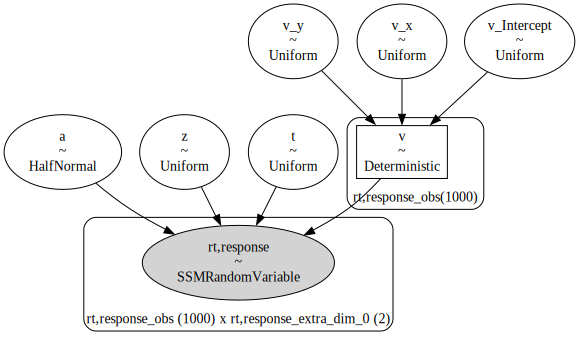

In [21]:
# Uncomment to see model graph if you have graphviz installed
# model_reg_v.graph()

In [22]:
trace_reg_v = model_reg_v.sample()

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_x, v_y]
INFO:pymc.sampling.mcmc:NUTS: [z, a, t, v_Intercept, v_x, v_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [23]:
# Looks like parameter recovery was successful
az.summary(model_reg_v.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.537,0.010,0.518,0.556,0.000,0.000,3894.0,2676.0,1.0
a,1.493,0.025,1.444,1.541,0.000,0.000,3804.0,2682.0,1.0
t,0.540,0.016,0.510,0.569,0.000,0.000,3590.0,2948.0,1.0
v_Intercept,0.111,0.079,-0.025,0.274,0.001,0.001,4659.0,3013.0,1.0
v_x,0.781,0.165,0.482,1.000,0.002,0.002,4567.0,2194.0,1.0
v_y,0.439,0.229,0.010,0.830,0.004,0.003,3297.0,1812.0,1.0


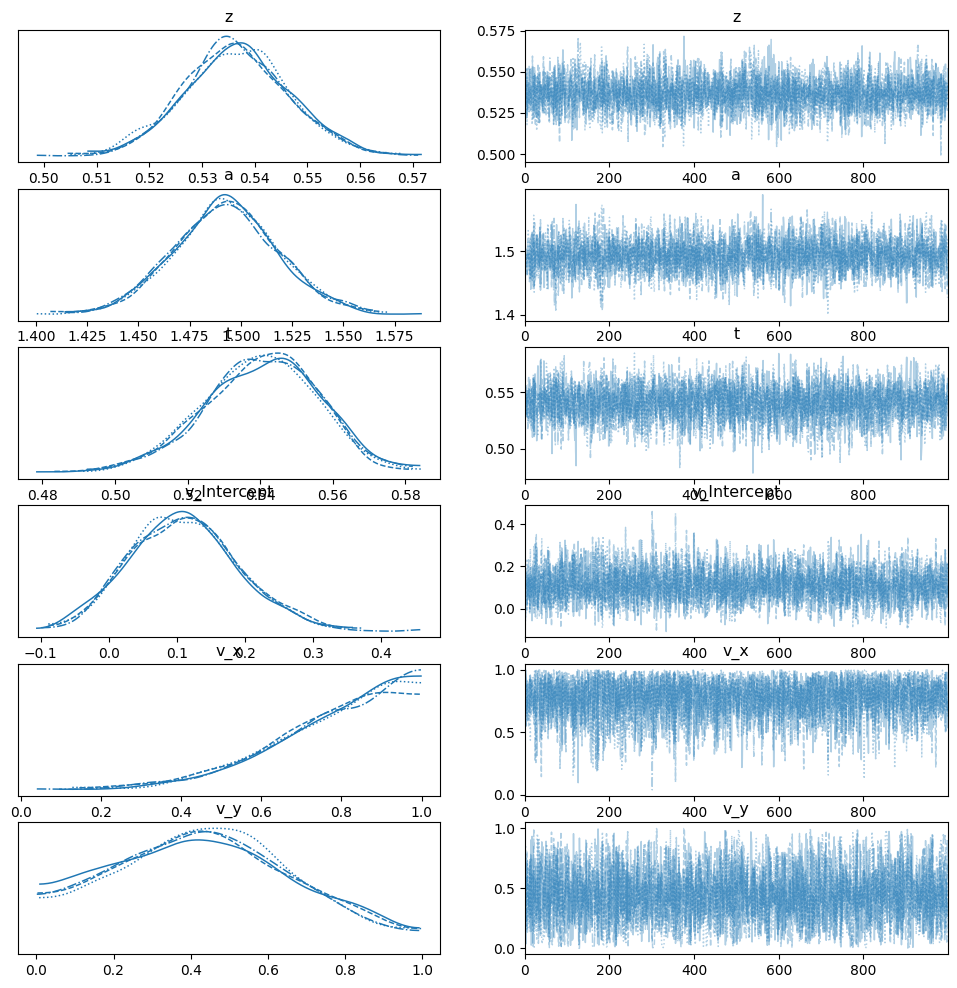

In [24]:
az.plot_trace(model_reg_v.traces);